# Assignment 1 - class scheduling

## Initialization

In [20]:
import matplotlib.pyplot as plt

class Timeslot():
    def __init__(self, start, end, color, title):
        self.start = start
        self.end = end
        self.color = color
        self.title = title

def applyTimeslots(offset, limit, timeslots, ax):
    for timeslot in timeslots:
        ax.fill_between([offset + 0.05, limit - 0.05], [timeslot.start + 0.05, timeslot.start + 0.05], [timeslot.end - 0.05,timeslot.end - 0.05], color=timeslot.color, edgecolor='k', linewidth=0.5, alpha=0.4
                        )
        ax.text(float(limit - offset) / 2 + offset, (timeslot.start + timeslot.end) / 2, timeslot.title, ha="center", va="center", fontsize=12)
        
def plotDay(timeslots):
    width = 10
    height = 8
    
    fig = plt.figure(figsize=(width, height))
    
    margin = 0.3
    
    ax = fig.add_subplot(111)
    ax.yaxis.grid()
    ax.set_ylabel("Time")
    ax.axes.get_xaxis().set_visible(False)
    fig.gca().invert_yaxis()

    applyTimeslots(margin, width - margin, timeslots, ax)
    
    ax.set_title("Day")
    
    plt.show()
    
def plotWeek(timeslotDays, dayStartAndEnd = None, title = None):
    width = 15
    height = 8
    weekdays = 7
    
    fig = plt.figure(figsize=(width, height))
    
    margin = 0.3
    
    ax = fig.add_subplot(111)
    ax.yaxis.grid()
    
    if dayStartAndEnd != None:
        (start, end) = dayStartAndEnd
        
        plt.yticks(range(start, end + 1))
        fig.gca().set_ylim([start,end])
    
    ax.set_ylabel("Time")
    #ax.axes.get_xaxis().set_visible(False)
    
    fig.gca().invert_yaxis()
    
    dayWidth = width / weekdays
    
    def genDays(): 
        days = ["Monday", "Tuesday", "Wensday", "Thursday", "Friday", "Saturday", "Sunday"]
        
        
        fig.gca().set_xlim([0,len(days)])
        

        for i, day in enumerate(days):
            yield (day, i * dayWidth + (dayWidth / 2))
            
    tickedDays = list(genDays())
    
    plt.xticks(list(map(lambda x: x[1], tickedDays)), list(map(lambda x: x[0], tickedDays)))
    
    for i, dayTimeslots in enumerate(timeslotDays):
        offset = i * dayWidth
        
        applyTimeslots(offset, offset + dayWidth, dayTimeslots, ax)

    if title != None:
        ax.set_title(title)
    else:
        ax.set_title("Week")
    
    plt.show()
    
    

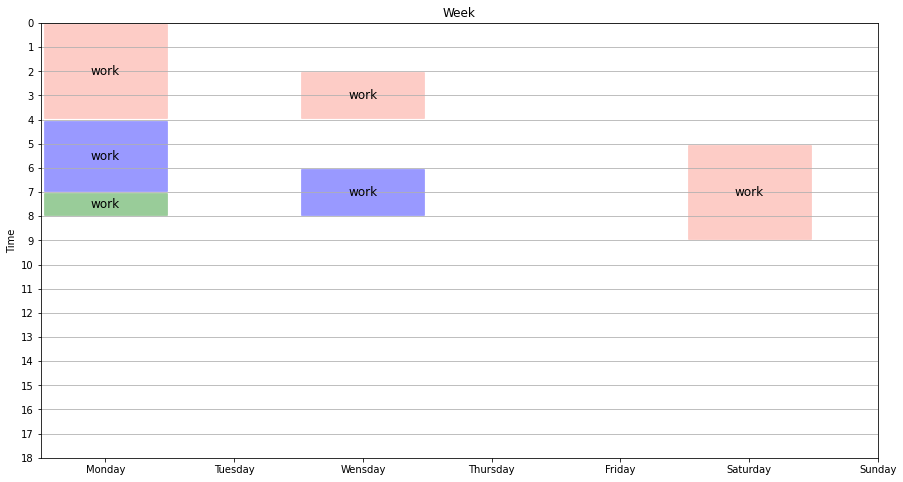

In [2]:
slots1 = [Timeslot(0, 4, "salmon", "work"), Timeslot(4, 7, "Blue", "work"), Timeslot(7, 8, "Green", "work")]
slots2 = []
slots3 = [Timeslot(2, 4, "salmon", "work"), Timeslot(6, 8, "Blue", "work")]
slots4 = []
slots5 = []
slots6 = [Timeslot(5, 9, "salmon", "work")]
slots7 = []

plotWeek([slots1, slots2, slots3, slots4, slots5, slots6, slots7], (0, 18))

## Model

## Initial description

We have:
* $P = (h,d,w)| h \in \text{Hours, } d \in \text{Days, } w \in \text{Weeks}$ 
* Rooms $R$
* Classes $E$ with duration $\ell(e), e \in E$
* Presedence digraph $D = (E, A)\text{, } uv \in A \text{ for } u, v \in E$
* Students $S$ and teachers $T$ with:
    * Enrollments $Q = E_s \subset E | s \in S$
    * Teaching duties $D = D_t \subset E | t \in T$
    * Unavailabilites $\mathcal{U} = U_t \subset P | t \in T$
    
Additionally I will use $B_r$ as the collection of busy times for a given room, eg $B = \{ B_r \subset P \,|\, r \in R \}$, not this includes the banned slots from `timeslots.json` and busy from `rooms.json`.

## Model interpretation

### Hard constraints

All classes should be allocated in their designated weeks.
$$x_{erp} \in \{0, 1\}$$
$$\sum_{(h,d,w) \in P, r \in R} x_{e,r,(h,d,week(e))} = 1, \forall e \in E$$

Classes should never overlap and range their full duration.
$$\sum_{e \in E} \, \sum^h_{i=max(0, h - \ell(e) + 1)} x_{e,r,(i,d,w)} \leq 1, \, \forall (h,d,w) \in P, \, \forall r \in R$$

A teacher may not teach two classes at the same time, no more than one room may ever be occupied by a class that requires the same teacher within the entire timeframe of a lecture.
$$\sum_{e \in d_e} \, \sum_{r \in R} \, \sum^h_{i=max(0, h - \ell(e) + 1)} x_{e,r,(i,d,w)} \leq 1, \, \forall (h,d,w) \in P, \, \forall d_e\in D$$

A room should never be occupied during a busy period.
$$\sum^h_{i=max(0, h - \ell(e) + 1)}  x_{e,r,(i,d,w)} = 0 ,\, \forall (h,d,w) \in B_r ,\, \forall e \in E ,\, \forall r \in R$$

The presedence graph should be followed, basically we get the "activation" day, if the class is allocated in day $3$ its binary value will be $1$, thus the allocated day will be $1*3$.
The difference between the in-arc vertex's day in $e_1$ and the current day in $e_2$ must be at least $1$ (in favor of the preceding vertex being larger).
The complexity of this constraint is actually quite small, since all the relevant $p \in P$ are only the ones containing $w = week(e_2) , \, (h,d,w) \in P$
$$\sum_{r \in R} \, \sum_{(h,d,w) \in P} x_{e_2,r,(h,d,week(e_2)} * d - \sum_{r \in R} \, \sum_{(h,d,w) \in P} x_{e_1,r,(h,d,week(e_1)} * d \geq 1, \, \forall e_1e_2 \in A, \, \forall e_2 \in E$$

For each course, there may only be one event per day for each student.
$$\sum_{r \in R} \sum_{e \in q_e} \sum_{h' \in H_{d,w}} x_{e,r,(h',d,w)} \leq 1, \, \forall (h,d,w) \in P, \, \forall q_e \in Q$$

We should of course also handle the case that the events do not exceed the day, eg a lecture of duration $\ell(e)$ may never begin at $final_{d,w} - \ell(e) + 1$ up to $final_{d,w,}$, final being the final hour slot of the day.
$$\sum^{final_{d,w}}_{i=max(0, final_{d,w} - \ell(e) + 1)} x_{e,r,(i,d,w)} = 0 , \, \forall (d,w) \in P , \, \forall e \in E , \, \forall r \in R$$

### Soft constraints

The soft constraints are where the quality of the model is gained.

Discomfort is minimized in regard to bad slots.
We let $O$ be the set of $c_p$ where $p \in P$ and $c \in \mathbb{N}$, $c$ being an arbitrary weight of how "bad" a timeslot is. The minimum value this $c$ may take is $1$, if a "perfect" fit would take the value $0$ it would invalidate any multiplicative terms $\alpha = 0, \alpha * ml * \beta.= 0$.
$$\alpha = \sum_{(h,d,w) \in P} \, \sum_{e \in E} \, \sum_{r \in R} \, \left( \sum^h_{i=max(0, h - \ell(e) + 1)} x_{e,r,(i,d,w)} \right) * c_{h,d,w}$$

The number of events per day for a teacher is minimized, it should be noted that $(d,w) \in P$ are all **distinct** $(d,w)$ pairs.
We find the maximum lectures $ml$ of any one day for any one teacher, this should be minimized. An average case minimization is harder to formulate because of the requirement of linearity (a sum of squares technique would be a nice alternative).
$$ml \geq \sum_{e \in d_e} \, \sum_{h' \in H_{d,w}} \, \sum_{r \in R} x_{e,r,(h',d,w)}, \, \forall (d,w) \in P, \, \forall d_e \in D$$

Like above, an average case analysis is difficult, so we settle with the above strategy. I employ the same strategy as above; minimization of the maximum amount of concurrent events for a student for any given time.
$$\beta \geq \sum_{e \in q_e} \sum_{r \in R} \, \sum^h_{i=max(0, h - \ell(e) + 1)} x_{e,r,(i,d,w)} , \, \forall (h,d,w) \in P , \, \forall q_e \in Q$$

Weekly stability in regard to events being scheduled the same day every week, we find the day where the maximum amount of events take place, we then maximize this.
A course is $e \in C \subset E$.
$$\delta_C \geq \sum_{e \in C} \,\sum_{r \in R} \, \sum_{(h,w) \in P} x_{e,r,(h,d,w)}, \, \forall d \in P, \, \forall C$$
Note the importance of restricting events to courses.

## Code

### Initilization

In [4]:
import pyomo.environ as po
import src.data as imp
import time
from datetime import datetime

dataImporter = imp.Data("data/small")

slots = dataImporter.slots
banned = dataImporter.banned
events = dataImporter.events
teachers = dataImporter.teachers
students = dataImporter.students
rooms = dataImporter.rooms

def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item
        

In [5]:
class ModelDataMapping:
    def __init__(self, E, P, R, D, T, B, S, Q, O, C, namedEvents, indexedRooms, teacherPairs, courseIdToTeacherMapping, eventLookup, eventIdToCourseId, dayWeekMaxHrPairs):
        self.E = E
        self.P = P
        self.R = R
        self.D = D
        self.T = T
        self.B = B
        self.S = S
        self.Q = Q
        self.O = O
        self.C = C
        self.namedEvents = namedEvents
        self.indexedRooms = indexedRooms
        self.teacherPairs = teacherPairs
        self.courseIdToTeacherMapping = courseIdToTeacherMapping
        self.eventLookup = eventLookup
        self.eventIdToCourseId = eventIdToCourseId
        self.dayWeekMaxHrPairs = dayWeekMaxHrPairs

def prepareModel(events, students, teachers, slots, banned, rooms):
    print("Preparing data")
    rooms_as_list = list(rooms.items())
    
    R = list(range(len(rooms_as_list)))
    namedEvents = [(eventSet, e) for eventSet in events for e in events[eventSet]]
    E = list(range(len(namedEvents)))
    P = [(s["hour"], s["day"], s["week"]) for s in slots]
    preparedBanned = [(b["hour"], b["day"], b["week"]) for b in banned]
    
    eventIdToIndex = dict([(e[1]["id"], i) for i, e in enumerate(namedEvents)])
    teacherPairs = list(teachers.items())
    T = range(len(teacherPairs))

    def indexedTeacherEvents():
        for teacherId, eventsForTeacher in teacherPairs:
            onlyEvents = [e["events"] for e in eventsForTeacher]

            flattenedEvents = [eventIdToIndex[b] for a in onlyEvents for b in a]

            yield flattenedEvents
    
    D = list(indexedTeacherEvents())
    
    studentPairs = list(students.items())
    S = range(len(studentPairs))
    
    def indexedStudentEvents():
        for studentId, eventsForStudent in studentPairs:
            onlyEvents = [e["events"] for e in eventsForStudent]

            flattenedEvents = [eventIdToIndex[b] for a in onlyEvents for b in a]

            yield flattenedEvents
            
    U = list(indexedStudentEvents())
    
    def busyRoomsForTimeAndBanned():
        # For O(1) lookup
        PAsSet = set(P)
        
        def formatEvent(e):
            return (e["hour"], e["day"], e["week"])

        for roomIndex, r in enumerate(rooms_as_list):
            (k, v) = r

            formattedBusyEvents = list(map(lambda e: formatEvent(e), v["busy"]))
            
            # filter out all events that do not exist in the timeslots data-set
            def removeInvalidTimes():
                for p in formattedBusyEvents:
                    if p in PAsSet:
                        yield p
                        
            def removeInvalidBannedTimes():
                for p in preparedBanned:
                    if p in PAsSet:
                        yield p
            
            yield (roomIndex, list(removeInvalidTimes()) + list(removeInvalidBannedTimes()))

    B = dict(busyRoomsForTimeAndBanned())
    
    # courseId to teacher mapping
    courseIdToTeacherMapping = [ [] for i in range(len(E)) ]

    for teacherIdx, d in enumerate(D):
        for e in d:
            courseIdToTeacherMapping[e].append(teacherIdx)
            
    def eventLookup():
        for i, (k, v) in enumerate(namedEvents):
            yield (v["id"], i)
            
    def eventIdToCourseId():
        for courseId, event in namedEvents:
            yield (event["id"], courseId)
            
    def dayWeekMaxHrPairs():
        def genDWHPairs():
            for (h,d,w) in P:
                yield ((d,w), h)
        
        dwh = list(genDWHPairs())
        
        for k in dict(dwh):
            yield (k, max(map(lambda x: x[1], filter(lambda x: x[0] == k, dwh))))
            
    EidtoCid = dict(list(eventIdToCourseId()))
    
    elook = dict(list(eventLookup()))
    
    dwmhrp = dict(dayWeekMaxHrPairs())
            
    def orderStudentClassesIntoCourses():
        for u in U:
            # Get course type
            courseIdMap = {}
            
            for e in u:
                courseId = namedEvents[e][0]
                courseIdMap.setdefault(courseId,[]).append(e)
                
            yield courseIdMap
            
    Q = list(orderStudentClassesIntoCourses())
    
    def genO():
        for ((d,w), maxHr) in dwmhrp.items():
            # lectures in hr 8 for all is rating 5 bad
            # lectuers in hr 16 for mon, tues, wed, thur is rating 3 bad
            # lectures in hr 17 for -||- is rating 4 bad
            # lectures in hr 15, 16 and 17 for fri is rating 6 bad
            def fillNs(start, end, n = 1):
                return list(map(lambda h: ((h,d,w), n), range(start, end + 1)))
            
            offset = 8
            
            if d in list(range(0, 4)):
                out = [((8 - offset,d,w), 5)] + fillNs(9 - offset,15 - offset) + [((16 - offset,d,w), 3), ((17 - offset,d,w), 4)] + fillNs(18 - offset,maxHr, 10)
            else:
                out = [((8 - offset,d,w), 5)] + fillNs(9 - offset,14 - offset) + [((15 - offset,d,w), 6), ((16 - offset,d,w), 6), ((17 - offset,d,w), 6)]  + fillNs(18 - offset,maxHr, 10)
                
            for o in out:
                yield o
                
    O = dict(list(genO()))
    
    C_build = {}

    for e in E:
        courseId = namedEvents[e][0]
        C_build.setdefault(courseId,[]).append(e)
            
    C = list(map(lambda x: x[1], list(C_build.items())))
            
    return ModelDataMapping(E, P, R, D, T, B, S, Q, O, C, namedEvents, rooms_as_list, teacherPairs, courseIdToTeacherMapping, elook, EidtoCid, dwmhrp)
        

In [8]:
def printD(*kwargs):
    print(datetime.time(datetime.now()), end=' - ')
    for a in kwargs:
        print(a, end = ' ')
    print('')

def solveModel(preparedData):
    E = preparedData.E
    P = preparedData.P
    R = preparedData.R
    D = preparedData.D
    T = preparedData.T
    B = preparedData.B
    S = preparedData.S
    Q = preparedData.Q
    O = preparedData.O
    C = preparedData.C
    
    def duration(eventIndex):
        return preparedData.namedEvents[eventIndex][1]["duration"]
    
    printD("Generating 5d/3d matrix of size", len(E) * len(R) * len(P))
    domain = [(e, r, p[0], p[1], p[2]) for e in E for r in R for p in P]
    
    m = po.ConcreteModel("timetable")
    
    printD("Adding variable x")
    m.x = po.Var(domain, bounds = (0, 1), within=po.Binary)
    
    printD("Adding soft constraints")
    '''
    printD("Adding delta")
    m.delta = po.Var(range(len(C)) , within=po.NonNegativeReals)
    m.delta_constraint = po.ConstraintList()
    
    daySet = list(set([d for (h,d,w) in P]))
    hrWeekSet = list(set([(h, w) for (h,d,w) in P]))
    
    for c in range(len(C)):
        for d in daySet:
            m.delta_constraint.add(m.delta[c] >= sum(
                sum(
                    sum(
                        m.x[e,r,(h,d,w)]
                    for (h,w) in hrWeekSet)
                for r in R)
            for e in C[c]))
    
    
    printD("Adding beta")
    m.beta = po.Var(within=po.NonNegativeReals)
    m.beta_constraint = po.ConstraintList()
    
    # Remove duplicate studetns
    def qUnique():
        for qs in Q:
            yield [z for y in list(map(lambda x: x[1], qs.items())) for z in y]
    Q_d = list(uniq(list(qUnique())))
    
    for i, qe in enumerate(Q_d):
        printD("For student", i, "/", len(Q_d))
        for (h,d,w) in P:
            m.beta_constraint.add(m.beta >= sum(
                sum(
                    sum(m.x[(e,r,(i, d, w))] for i in range(max(0, h - duration(e) + 1), h + 1))
                for r in R)
            for e in qe))
    '''
    printD("Adding ml")
    m.ml = po.Var(within=po.NonNegativeReals)
    
    m.ml_constraint = po.ConstraintList()
    
    for i, de in enumerate(D):
        print("For teacher",i,"/",len(D))
        for ((d,w), maxHr) in preparedData.dayWeekMaxHrPairs.items():
            rangeToMaxHr = range(0, maxHr + 1)
            
            mlExpr = sum(
                sum(
                    sum(
                        m.x[e,r,(hPrime,d,w)]
                    for r in R)
                for hPrime in rangeToMaxHr)
            for e in de)
            
            m.ml_constraint.add(mlExpr <= m.ml)
                
    
    printD("Adding alpha")
    m.alpha = po.Var(within=po.NonNegativeReals)
    m.alpha_constraint = po.ConstraintList()
    m.alpha_constraint.add(m.alpha == sum(
        sum(
            sum(
                sum(m.x[(e,r,(i, d, w))] for i in range(max(0, h - duration(e) + 1), h + 1)) * O[(h,d,w)]
            for r in R)
        for e in E)
    for (h,d,w) in P))
    
    m.value = po.Objective(expr=m.alpha + m.ml)# + m.beta - sum(m.delta[c] for c in range(len(C))), sense=po.minimize)
    
    printD("Adding hard constriants")
    
    m.do_not_exceed = po.ConstraintList()
    
    printD("Adding do not exceed day constraint")
    for r in R:
        for e in E:
            for ((d,w), maxHr) in preparedData.dayWeekMaxHrPairs.items():
                m.do_not_exceed.add(sum(m.x[(e,r,(i, d, w))] for i in range(max(0, maxHr - duration(e) + 1), maxHr + 1)) == 0)
    
    m.scheduled = po.ConstraintList()
    
    printD("Adding scheduled constraint")
    
    def weekFor(e):
        return preparedData.namedEvents[e][1]["week"]
    
    for e in E:
        weekForE = weekFor(e)
        relevantPs = list(filter(lambda p: p[2] == weekForE, P))
        irellevantPs = list(filter(lambda p: p[2] != weekForE, P))
        
        m.scheduled.add(expr = sum(m.x[(e,r,h,d,w)] for (h,d,w) in relevantPs for r in R) == 1)
        m.scheduled.add(expr = sum(m.x[(e,r,h,d,w)] for (h,d,w) in irellevantPs for r in R) == 0)
    
    m.one_event_per_student_day = po.ConstraintList()
    
    printD("Adding one event per course per day per student")
    for q in Q:
        for courseId, SE in q.items():
             for ((d,w), maxHr) in preparedData.dayWeekMaxHrPairs.items():
                rangeToMaxHr = range(0, maxHr + 1)

                m.one_event_per_student_day.add(sum(sum(sum(m.x[e,r,h,d,w] for h in rangeToMaxHr) for e in SE) for r in R) <= 1)
                    
            
    
    m.presedence = po.ConstraintList()
    
    def getActivationDay(e, relevantPs):
        return sum(sum(m.x[e,r,h,d,w] * d for (h, d, w) in relevantPs) for r in R)
    
    printD("Adding presedence graph")
    for e2 in E:
        in_arcs = preparedData.namedEvents[e2][1]["in_arcs"]
        weekForE = weekFor(e2)
        relevantPs = list(filter(lambda p: p[2] == weekForE, P))
        
        for arcSourceId in in_arcs:
            e1 = preparedData.eventLookup[arcSourceId]
            
            m.presedence.add(getActivationDay(e2, relevantPs) - getActivationDay(e1, relevantPs) >= 1)
    
    m.no_teach_busy = po.ConstraintList()
    
    printD("Adding no classes in busy period constraint")
    for r in R:
        for e in E:
            for (h,d,w) in B[r]:
                m.no_teach_busy.add(sum(m.x[(e,r,(i, d, w))] for i in range(max(0, h - duration(e) + 1), h + 1)) == 0)
        
    
    m.only_teach_one_class = po.ConstraintList()
    
    printD("Adding teacher only teaches one class at a time constriants")
    for de in D:
        for p in P:
            (h, d, w) = p

            m.only_teach_one_class.add(sum(sum(sum(m.x[(e,r,(i, d, w))] for i in range(max(0, h - duration(e) + 1), h + 1)) for r in R) for e in de) <= 1)
    
    m.overlap = po.ConstraintList()
    
    printD("Adding overlap constriants")
    for r in R:
        for p in P:
            (h, d, w) = p

            m.overlap.add(sum(sum(m.x[(e,r,(i, d, w))] for i in range(max(0, h - duration(e) + 1), h + 1)) for e in E) <= 1)
    
            
    printD("Solving...")    
        
    now = time.time()
        
    res = po.SolverFactory("gurobi").solve(m, tee=(False))
    
    later = time.time()
    difference = int(later - now)
    
    printD("Done in", difference, "seconds")
            
    return m, res
            
    

In [9]:
modelDataMapping = prepareModel(events, students, teachers, slots, banned, rooms)
#for k, v in modelDataMapping.B.items():
#    l = list(filter(lambda x: x[0] > 11, v))
#    if len(l) != 0:
#        print(l)

#print(modelDataMapping.Q)

#for e1 in modelDataMapping.E:
#    in_arcs = modelDataMapping.namedEvents[e1][1]["in_arcs"]
#    week1 = modelDataMapping.namedEvents[e1][1]["week"]

#    for arcSourceId in in_arcs:
#        e2 = modelDataMapping.eventLookup[arcSourceId]
#        week2 = modelDataMapping.namedEvents[e2][1]["week"]
        
#        if week1 == week2:
#            print(e1, e2)

#for qes in modelDataMapping.Q:
#    # This student is a dict courseId -> events
#    onlyEvents = list(map(lambda x: x[1], qes.items()))
#    qe = [es for b in onlyEvents for es in b]
#    print(qe)

model, result = solveModel(modelDataMapping)

Preparing data
09:38:29.499883 - Generating 5d/3d matrix of size 2419200 
09:38:29.755311 - Adding variable x 
09:38:37.751051 - Adding soft constraints 
09:38:37.751132 - Adding ml 
For teacher 0 / 8
For teacher 1 / 8
For teacher 2 / 8
For teacher 3 / 8
For teacher 4 / 8
For teacher 5 / 8
For teacher 6 / 8
For teacher 7 / 8
09:38:54.303354 - Adding alpha 
09:39:35.777729 - Adding hard constriants 
09:39:35.777858 - Adding do not exceed day constraint 
09:39:40.641764 - Adding scheduled constraint 
09:39:45.160882 - Adding one event per course per day per student 
09:41:11.114770 - Adding presedence graph 
09:41:11.557052 - Adding no classes in busy period constraint 
09:41:48.473594 - Adding teacher only teaches one class at a time constriants 
09:42:26.668708 - Adding overlap constriants 
09:42:54.570605 - Solving... 
09:46:37.069520 - Done in 222 seconds 


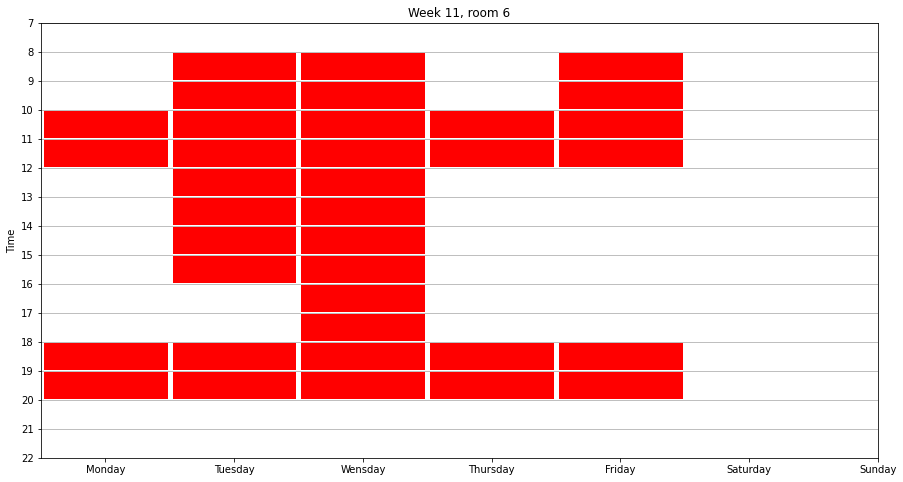

In [22]:
import matplotlib.colors as mcolors

color_map = {}

colorsAsList = list(mcolors.TABLEAU_COLORS.items())

for i, k in enumerate(events):
    color_map[k] = colorsAsList[i]
    
dayStart = 8
    
def plotFor(week, room):
    timeslots = [ [] for i in range(7) ]

    # plot data
    for e in modelDataMapping.E:
        for r in modelDataMapping.R:
            if r != room:
                continue

            for (h, d, w) in modelDataMapping.P:
                if w != week:
                    continue
                    
                s = set(modelDataMapping.B[r])
                
                namedEvent = modelDataMapping.namedEvents[e]
                
                if (h, d, w) in s:
                    timeslots[d].append(Timeslot(h + dayStart, h + dayStart + 1, "red", ""))
                    continue

                value = po.value(model.x[e,r,h,d,w])

                if value != 0:
                    color = color_map[namedEvent[0]]

                    teachersThatCanTeachThis = [str(teacherIdx) for teacherIdx in modelDataMapping.courseIdToTeacherMapping[e]]

                    timeslots[d].append(Timeslot(h + dayStart, h + dayStart + namedEvent[1]["duration"], color, namedEvent[1]["id"] + "\n" + ", ".join(teachersThatCanTeachThis)))

    plotWeek(timeslots, (7, 22), "Week " + str(week) + ", room " + str(room))


for e in [3,2]:#modelDataMapping.E[:10]:
    for r in modelDataMapping.R:
        for p in modelDataMapping.P:
            if po.value(model.x[e,r,p]) == 1:
                pass
                #plotFor(week=p[2],room=r)
                
plotFor(week=11, room=6)